In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
#plt.rc('font', family='NanumSquareRound') 

In [139]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumSquareRound') 

#목차

### 분석 배경 및 분석 목적
### 1.데이터셋 준비
#### 1-1) 결측치, 이상치 확인

###2. EDA
####2-1) 그래프
####2-2) 분석 

###3. 시계열 전처리
#### 3-1) 정상성 확인
#### 3-2) 정상성을 갖는 데이터로 바꾸기
#### 3-3) 특성 공학

###4. 모델 생성
####4-1) 모델 1: OLS
####4-2) 모델 2: XGBoost Regressor
#### 4-3) 모델 3: ARIMA
#### 4-4) 모델 4: XGBoost Classifier

###5. 모델 선택
####5-1) 하이퍼파라미터 튜닝을 통한 모델 최적화
####5-2) 최종모델

###6. 특성중요도
####6-1) 모델 예측에 중요한 특성 설명
####6-2) 개별 샘플을 예시로 예측 설명

###7. 번외) 다른 ETF 분석 및 포트폴리오 구성

###6. 주요 특성 설명

###7. 묶어서 포트폴리오 만들고 평가

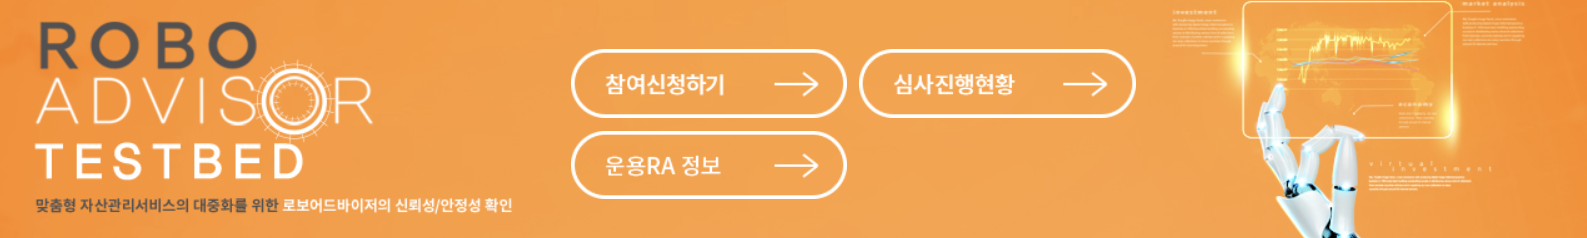

## 분석 배경

저는 데이터 분석회사에서 일하고 있는 직원입니다. 2016년부터 시작된 로보 어드바이저 사업이 이제는 많이 상용화가 되어 여러 증권사/은행/핀테크 기업에서 이미 로보 어드바이저 서비스를 시작하였습니다. 모든 기업이 각자 알고리즘을 개발해서 서비스를 하는 것이 아니라, 다른 데이터 기업과 협업해서 로보 어드바이저 사업을 하는 경우가 있어, 여기에 사용할 알고리즘을 개발하는 프로젝트를 제안하려고 합니다.

## 분석 목표

1. 종가가 20일 지수이동평균를 넘어서 수익을 낼 ETF를 예측한다.
2. 투자 성향별로 ETF를 분배한 후 이들의 평균수익률을 예측한다.

분석 모델은 시계열 회귀분석과 분류 모델을 설계한 후 더 적절한 모델을 선택할 예정입니다.타겟은 시계열 회귀분석의 경우 ETF의 차분이며, 분류 모델의 경우 타겟은 종가가 20일 지수평균을 초과하는 것입니다.타겟을 20일 지수이동평균 초과하는 것으로 정한 것은, 누적 수익률을 이용한 타겟인 것이 가장 적절하겠으나 분석의 편의성 및 로보 어드바이저의 평균 매매회전율이 높기 때문에(200%이상) 20일을 기준으로 설정하였습니다.

*매매회전율 = (매매대금 * 100) / (운용자금 * 2)

#1. 데이터셋 준비


여러 로보 어드바이저의 알고리즘 설명서를 분석한 결과 대부분의 로보 어드바이저는 ETF 위주의 투자를 하는 것을 알 수 있었습니다. 따라서 이번 분석에서는 ETF만을 사용하며, 위험도에 따라서 분류할 예정입니다.

제가 이번 분석에서 사용할 ETF의 선정기준은 시가총액 1000억 원 이상인 것들 중에 분야별(국내 시장지수, 국내 업종테마/국내 파생/해외 주식/원자재/채권)로 고르게 고르며, 생긴지 5년 이상된 지수들입니다.

위험도 분류는 
* 위험도 1: 채권
* 위험도 2: 국내 시장지수, 국내 업종테마, 국내 파생
* 위험도 3: 해외 주식, 원자재

3단계로 하며, 분류기준 역시 다른 알고리즘 설명서를 참고하였습니다. 

<알고리즘 설명서 예시>

디셈버ISAAC자산배분국내형]알고리즘설명서_디셈버앤컴퍼니

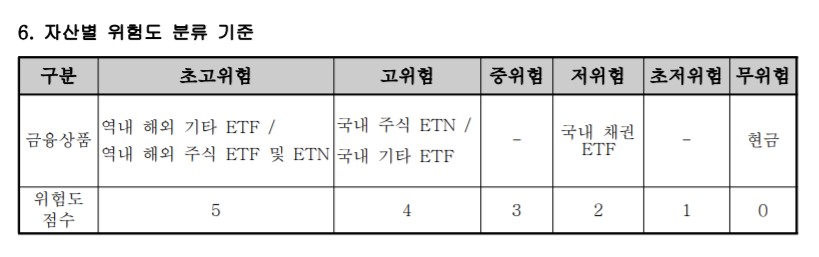

ETF 종목 선택은 분야별로 생긴지 10년 이상이 지난 ETF 중 거래량이 제일 많은 하나의 ETF 데이터를 사용할 예정입니다.

* 국내 지수: KODEX200
* 국내 업종 테마: Kodex 삼성그룹
* 국내 파생 지수: KODEX 레버리지
* 해외 지수: TIGER 미국나스닥 100
* 원자재: KODEX 골드선물(H)
* 채권: KODEX 단기채권

[벤치마크] Kospi200

앞으로 불러올 ETF들과 추세를 비교하기 위해서 Kospi200 지수를 불러오겠습니다.

In [3]:
import pandas_datareader.data as web
from datetime import datetime

kospi200 = web.DataReader('KPI200', 'naver', start='2011-02-01', end='2021-02-23')
kospi200

,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,274.5,275.46,273.44,273.45,105181
2011-02-07,277.76,278.68,274.9,274.9,112689
2011-02-08,276.01,276.36,272.84,273.16,114407
2011-02-09,274.18,274.2,268.84,269.9,106567
2011-02-10,269.21,269.83,264.57,264.57,116932
...,...,...,...,...,...
2021-02-17,429.2,429.24,421.77,424.2,230412
2021-02-18,423.92,425.38,417.44,417.44,181374
2021-02-19,417.98,421.36,411.58,420.94,246865


In [4]:
!pip install --upgrade mplfinance

     |████████████████████████████████| 61kB 3.3MB/s 


In [5]:
kospi200daily = kospi200[['Open','High','Low','Close','Volume']].iloc[-250:]
kospi200daily = kospi200daily.astype('float')

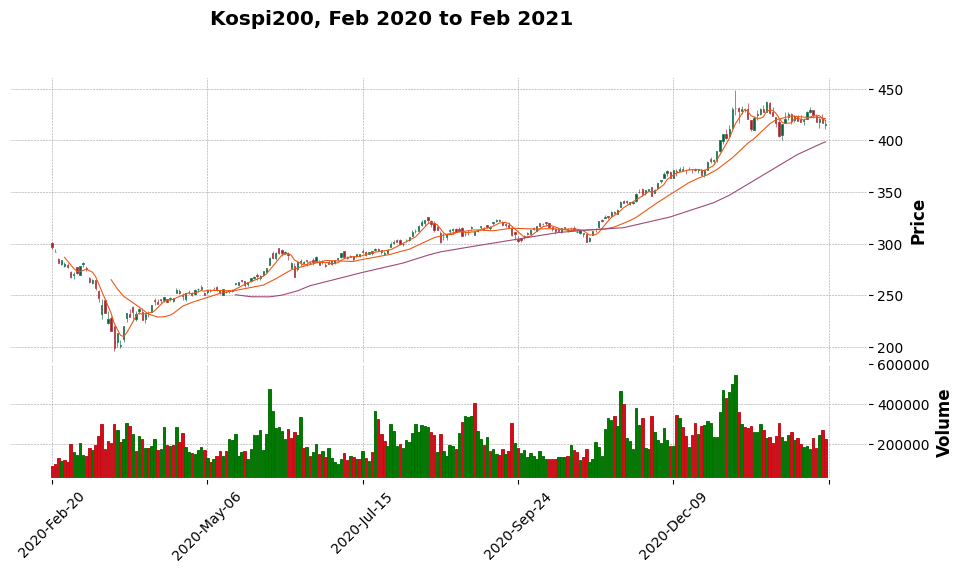

In [6]:
import mplfinance as mpf
mpf.plot(kospi200daily,type='candle',mav=(5,20, 60),
         style='charles', 
         title='Kospi200, Feb 2020 to Feb 2021',
         figratio=(29,14),volume=True)

Kospi200 그래프를 보면 지난 1년 간 Kospi200지수의 등락을 볼 수 있습니다. Kospi200 지수는 3월달에 가파르게 하락했다가 계속 완만하게 상승하는 모습을 확인할 수 있으며, 거래량은 증가와 감소를 반복하고 있습니다.

이제 이번 분석에서 사용할 ETF 중 하나인 kodex200을 예시로 어떤 분석방법이 가장 알맞을지 살펴보겠습니다.

## KODEX 200

KODEX200은 국내 Kospi 200 지수를 그대로 추종하는 ETF입니다. 분석의 편의와 여러 ETF 간의 시간 간격을 맞추기 위해 10년 간의 데이터를 불러옵니다.

In [7]:
import pandas_datareader.data as web
from datetime import datetime

kodex200  = web.DataReader('069500', 'naver', start='2011-02-01', end='2021-02-23')
kodex200

,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,23727,23787,23644,23698,640740
2011-02-07,23953,24067,23727,23778,1864167
2011-02-08,23858,23858,23576,23596,2594968
2011-02-09,23628,23678,23251,23333,1305562
2011-02-10,23319,23319,22936,23136,2615617
...,...,...,...,...,...
2021-02-17,43255,43270,42735,43025,17530618
2021-02-18,42950,43125,42385,42410,8841408
2021-02-19,42440,42805,41720,42780,9728222


### 결측치 확인

In [7]:
kodex200.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2477 entries, 2011-02-01 to 2021-02-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    2477 non-null   object
 1   High    2477 non-null   object
 2   Low     2477 non-null   object
 3   Close   2477 non-null   object
 4   Volume  2477 non-null   object
dtypes: object(5)
memory usage: 116.1+ KB


제가 사용한 api 특성 상 결측값은 불러와지지 않았습니다.

### 이상치 확인

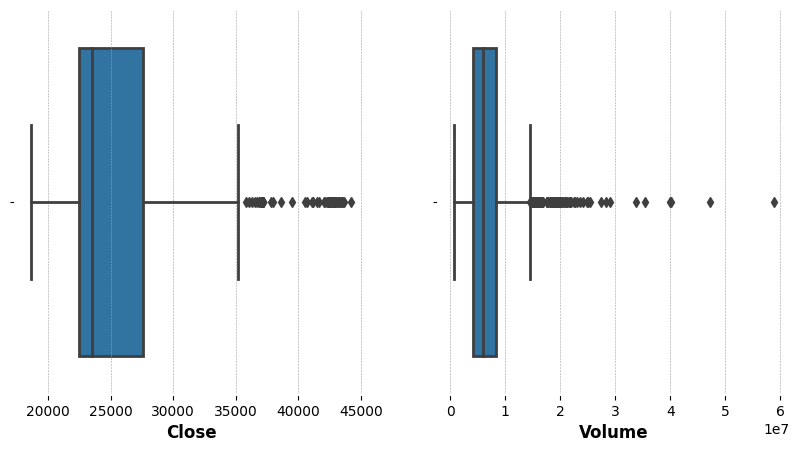

In [8]:
kodex200 = kodex200.astype('float')
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1 = sns.boxplot(kodex200['Close']);

ax2 = fig.add_subplot(1, 2, 2)

#ax1.plot(x, y)
#ax2.bar(x, y)

ax2=sns.boxplot(kodex200['Volume']);

plt.show()


그래프 상으로는 종가와 거래량에 이상치가 있는 것 같아 보입니다. 이를 아래 캔들차트를 통해서 자세히 알아보겠습니다.

In [9]:
kodex200daily = kodex200[-250:]
kodex200daily = kodex200daily.astype('float')

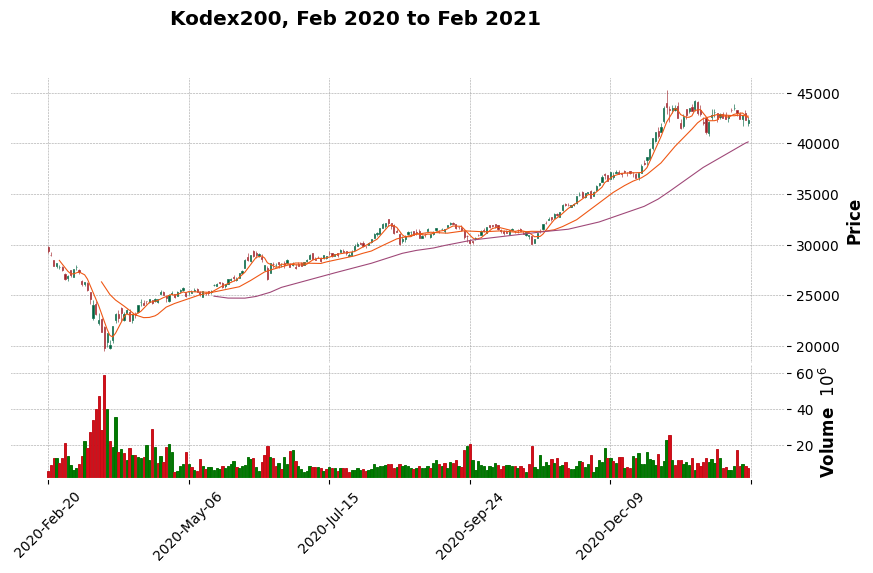

In [10]:
mpf.plot(kodex200daily,type='candle',mav=(5,20, 60),
         style='charles', 
         title='Kodex200, Feb 2020 to Feb 2021',
         figratio=(15,8),volume=True)


KODEX 200 지수의 캔들차트를 보면 KODEX200은 Kospi200를 그대로 추종하기 때문에 Kospi200과 비슷한 추세를 보이는 것을 알 수 있습니다. 지수가 폭락하던 3월에 거래량이 급증한 것만 KOSPI200과 다른 점입니다. 

종가는 계속 증가하는 추세이고, 거래량이 40,000,000이상인 값들을 이상치로 처리하기는 어려울 것 같아 그대로 사용하겠습니다.


이제 이번 분석에서 사용할 KODEX200의 10년치 추세를 보겠습니다.

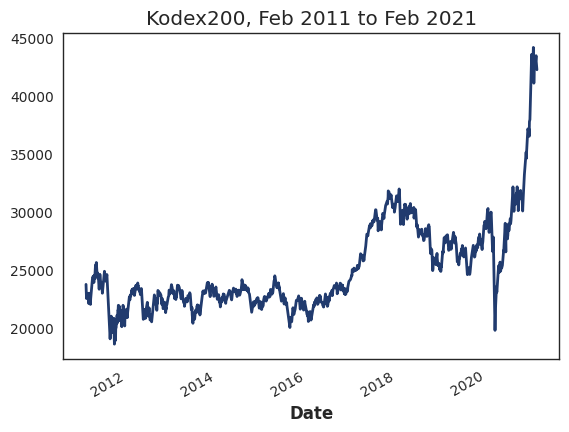

In [141]:
sns.set_style('white')
sns.set_palette('cividis')
kodex200 = kodex200.astype('float')
plt.title("Kodex200, Feb 2011 to Feb 2021")
kodex200['Close'].plot();

10년 간의 KODEX200지수를 보면 전반적으로는 증가하면서도 뚜렷한 계절성 특징을 보인다거나 선형으로 나타내기 어려워 보입니다.

시계열 모형은 크게 백색잡음, 랜덤워크, 자기회귀, 이동평균 모형으로 분류를 하는데, 주가예측은 대부분 랜덤워크 모형에 해당합니다.

랜덤워크 모형은 미래의 주가는 랜덤하게 결정되기 때문에, 이를 가장 잘 예측한 방법은 모든 정보가 반영된 현재 가격을 이용하는 것입니다. 따라서 이번 분석에서는 지난 ETF 종가를 이용해서 여러 특성을 만든 후에 이를 이용해서 미래 가격을 예측해보겠습니다.

또한, 이렇게 시계열 그래프가 긴 주기를 갖는 추세가 있지만 갑작스럽고 예측할 수 없는 방향의 변화가 있을 때는 데이터의 정상성을 확인해야 합니다. 정상성을 따르지 않는 시계열 데이터의 예측은 정확도가 많이 떨어지기 때문에 KODEX200 데이터가 정상성을 띠는지 확인해보겠습니다.



[랜덤워크 모형에 맞는 데이터]

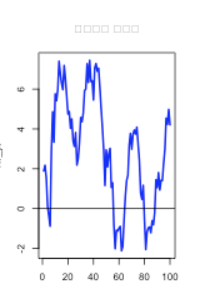

#시계열 데이터 전처리

###정상성(Stationarity) 확인


In [12]:
from statsmodels.tsa.stattools import kpss
print(kpss(kodex200['Close'], regression='ct') )

(0.5209123812685735, 0.01, 27, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


정상성을 확인하는 방법으로 kpss 테스트를 시행했는데, kpss 값은 0.52, p값은 0.01로 KODEX200지수 종가가 정상성을 띤다는 귀무가설을 기각합니다. 즉, KODEX200의 종가는 정상성을 따르지 않기 때문에 시계열분석에 적합하지 않습니다. (정상성 확인 전에 KODEX 200 종가로 모델을 돌렸더니 r2 score가 음수가 나왔습니다...) 

#### 정상성 갖는 데이터로 바꾸기(차분)

차분은 t기간의 데이터에서 t-1기간의 데이터를 뺀 값으로 여기서는 하루 간의 KDOEX200 종가 차이를 구합니다.

In [13]:
#차분 구하기
kodex200 = kodex200.astype('float')
kodex200['Diff'] =  np.r_[0, np.diff(kodex200['Close'])]
kodex200

,Open,High,Low,Close,Volume,Diff
Date,,,,,,
2011-02-01,23727.0,23787.0,23644.0,23698.0,640740.0,0.0
2011-02-07,23953.0,24067.0,23727.0,23778.0,1864167.0,80.0
2011-02-08,23858.0,23858.0,23576.0,23596.0,2594968.0,-182.0
2011-02-09,23628.0,23678.0,23251.0,23333.0,1305562.0,-263.0
2011-02-10,23319.0,23319.0,22936.0,23136.0,2615617.0,-197.0
...,...,...,...,...,...,...
2021-02-17,43255.0,43270.0,42735.0,43025.0,17530618.0,-470.0
2021-02-18,42950.0,43125.0,42385.0,42410.0,8841408.0,-615.0
2021-02-19,42440.0,42805.0,41720.0,42780.0,9728222.0,370.0


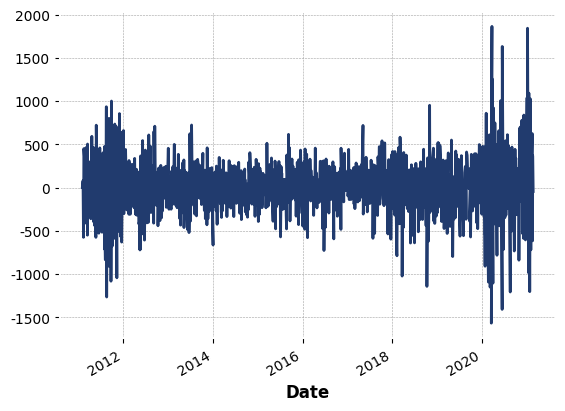

In [14]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_palette('cividis')
kodex200['Diff'].plot();

t기간의 KODEX200 종가에서 t-1기간의 KODEX200 종가를 뺀 차분을 구한 후 이를 그래프로 나타낸 것입니다. KODEX200지수 종가와는 다르게 일정한 분산을 보이는 것을 알 수 있습니다.

In [15]:
from statsmodels.tsa.stattools import kpss
print(kpss(kodex200['Diff'], regression='ct') )

(0.08434006108485467, 0.1, 27, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


KPSS 테스트를 해보면 KPSS값 0.084, p값 0.1로, p값이 0.05이상이기 때문에 데이터가 정상성을 따른다는 귀무가설을 기각하지 못합니다. 따라서 차분 데이터를 사용해서 분석을 진행할 수 있습니다.

이어서 차분한 종가의 자기상관을 알아보겠습니다. 많은 시계열 데이터는 고전적 회귀모형의 기본 가정인 오차항들끼리 독립이며, 등분산일 것을 만족하지 못하며 이를 자기상관이라고 부릅니다.

자기상관(autocorrelation)은 시계열의 시차 값(lagged values) 사이의 선형 관계를 측정합니다. 정상성을 만족하지 못하는 KODEX200 종가는 자기상관현상을 보이기 때문에 바로 분석에 이용하기는 어렵습니다. 



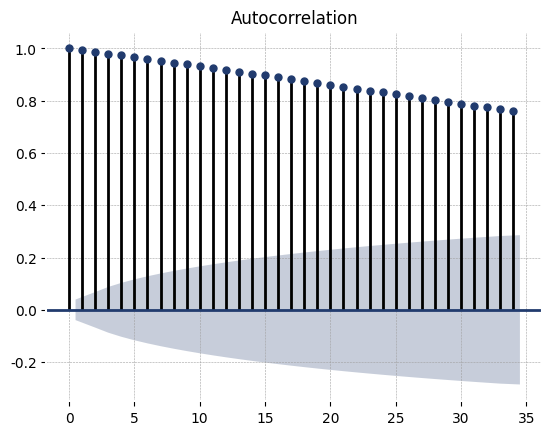

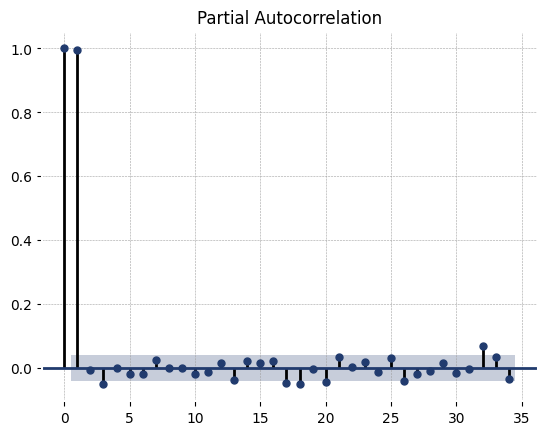

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kodex200['Close'])
plot_pacf(kodex200['Close'])
plt.show()

KODEX200 종가를 이용해서 그린 acf, pacf 그래프입니다. acf 그래프를 보면 잔차가 일정한 패턴을 보이며 자기상관 현상을 보이고 있습니다.

이와 비교하기 위해 차분한 데이터의 자기상관을 알아보기 위한 acf, pacf 그래프를 그려보겠습니다. 

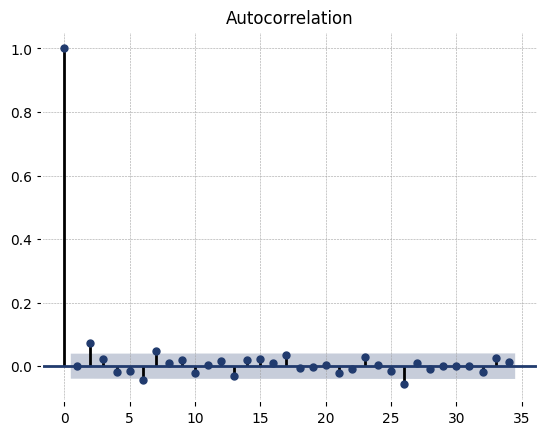

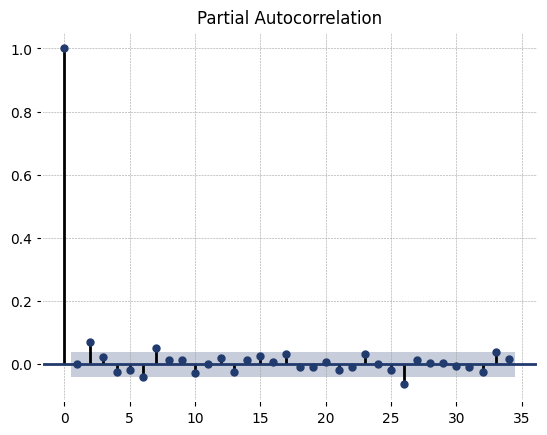

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kodex200['Diff'])
plot_pacf(kodex200['Diff'])
plt.show()

KODEX200종가의 차분 데이터는 잔차가 일정하기 때문에 자기상관현상을 보이지 않습니다. 이는 시계열 데이터가 정상성을 띠면 자기상관함수는 시간에 따라 일정해지기 때문입니다.

그외에도 수익률 데이터로 정상성 테스트를 진행할 수 있습니다. 

#### 정상성을 갖는 데이터로 바꾸기(일일수익률)

In [18]:
kodex200['return'] = kodex200['Close'].pct_change() * 100  #pct_change(5) 5일간 수익률
kodex200 = kodex200.dropna()

In [19]:
print(kpss(kodex200['return'], regression='ct') )

(0.060296389606724274, 0.1, 27, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


일일수익률 역시 KPSS 테스트 결과 p값이 0.05이상이기 때문에 귀무가설을 기각하지 못해서 KODEX200의 일일수익률 데이터는 정상성을 보입니다.

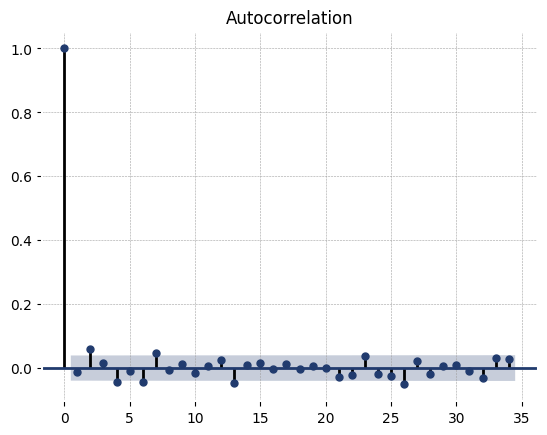

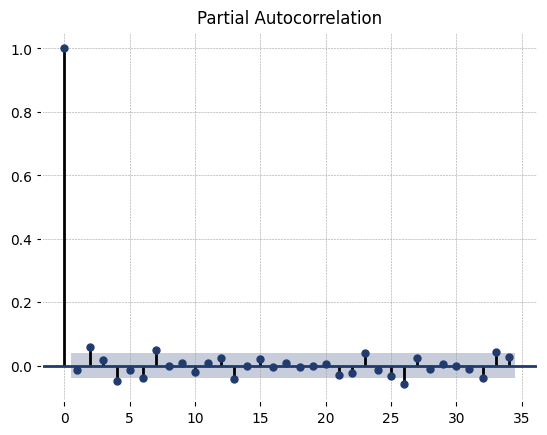

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kodex200['return'])
plot_pacf(kodex200['return'])
plt.show()

수익률의 acf, pacf 그래프를 살펴보면 차분 데이터와 마찬가지로 자기상관현상을 보이지 않는 것을 알 수 있습니다.

#특성 공학

랜덤 워크 모델이기 때문에 지수 종가를 사용해서 만든 특성을 이용해서 분석합니다. 새롭게 만들 특성은 5일 단순이동평균, 5일 지수이동평균, 이격도, Stochastic %K(Slow), %D(Slow), MACD, RSI입니다. 위의 특성들은 지수 종가와 고가, 저가를 이용한 특성들로 논문을 참고하였습니다. 

참고 논문: 하대우(연세대학교) 외. (2019.05).XGBoost 모형을 활용한 코스피 200 주가지수 등락 예측에 관한 연구.한국데이터정보과학회

In [21]:
def engineer(df):
  df = df.astype('float')
  
  #5일 단순이동평균(sma)
  df['sma5'] = df['Close'].rolling(window=5, min_periods=1).mean()

  
  #5일 지수이동평균(ema)
  df['ema5'] = df['Close'].ewm(5).mean()
  #20일 지수이동평균
  df['ema20'] = df['Close'].ewm(20).mean()

  #이격도
  df['disparity'] = df['Close'] - df['sma5']
  
  #Stochastic K, D : Fast %K의 m기간 이동평균(SMA)
  df['fast_k'] = ((df['Close'] - df['Low'].rolling(5).min()) / (df['High'].rolling(5).max() - df['Low'].rolling(5).min())) * 100
  df['Slow_k'] = df['fast_k'].rolling(3).mean()
  df['Slow_d'] = df['Slow_k'].rolling(3).mean()

  #MACD
  df['EMAFast'] = df['Close'].ewm( span = 5, min_periods = 4).mean()
  df['EMASlow'] = df['Close'].ewm( span = 20, min_periods = 19).mean()
  df['MACD'] = df['EMAFast'] - df['EMASlow']
  #df['MACDSignal'] = df['MACD'].ewm( span = 9, min_periods = 8).mean()
  #df['MACDDiff'] = df['MACD'] - df['MACDSignal']

  #RSI
  delta = df['Close'].diff(5)
  delta = delta.dropna()

  up = delta.copy()
  down = delta.copy()

  up[up<0] = 0
  down[down>0] = 0

  df['up'] = up
  df['down'] = down

  AVG_Gain = df['up'].rolling(window = 5).mean()
  AVG_Loss = abs(df['down'].rolling(window = 5).mean())
  RS = AVG_Gain/AVG_Loss

  RSI = 100.0 - (100.0/(1+RS))
  df['RSI'] = RSI 

  df['Diff'] =  np.r_[0, np.diff(df['Close'])]

  df = df.drop(columns=['Open', 'Close', 'High','Low', 'fast_k', 'EMAFast', 'EMASlow', 'up', 'down'])
  df = df.dropna()

  df = df.reset_index() #time_series_split할 때 필요


  return df

# 모델 생성

지난 과제를 통해서 주가 예측을 회귀 모델로 할 경우 r2 score가 높더라도 예측 가격이 실제 가격이랑 많이 다르게 나와서 분석이 어렵다고 느꼈습니다. 그렇지만 일단 분류문제로 풀기 전에 회귀분석으로 예측을 해서 수익률 예측을 해보겠습니다.

##회귀분석 모델

* 모델 1: 다중선형회귀모델

* 모델 2: XGBoost 모델

* 모델 3: ARIMA 모델

회귀분석 모델 3가지를 만들 것인데, 타겟은 일일 종가의 차분으로 하고, 평가지표는 MSE, R2 score 두 가지를 사용하겠습니다.

## 테스트 데이터 분리
CV 이후 사용할 테스트 데이터를 분리합니다. 전체 데이터 중에서 최근 20%를 테스트 데이터로 사용하겠습니다.

In [22]:
len(kodex200)*0.2

495.20000000000005

In [23]:
kodex200test = kodex200[-495:]
kodex200train = kodex200.drop(index=kodex200test.index)
kodex200train.shape, kodex200test.shape

((1981, 7), (495, 7))

In [24]:
#특성 공학
kodex200train = engineer(kodex200train)
kodex200test = engineer(kodex200test)

In [25]:
kodex200train = kodex200train.drop(columns=['return'])
kodex200test = kodex200test.drop(columns=['return'])

## 모델 1 다중선형회귀분석

타겟을 차분으로 정했기 때문에 선형회귀 모델의 가정인 오차의 정규성, 등분산성, 독립성을 만족합니다.

시계열 데이터로 CV를 수행합니다. 이때 시계열을 고려하는 TimeSeriesSplit을 사용해서 적은 데이터를 조금이나마 효율적으로 사용해서 훈련합니다.

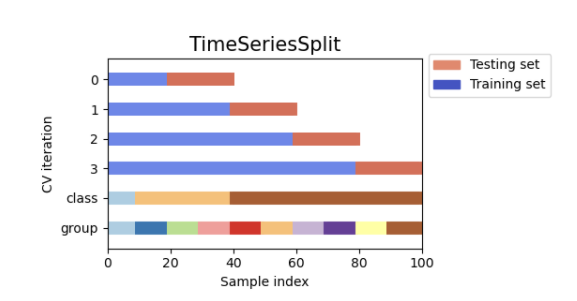

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=10)

target = 'Diff'
y =kodex200train[target]
X =kodex200train.drop(columns = target)

X = X.dropna()
y= y.dropna()

X = X.drop(columns='Date')

pred1 = []
scores = []
mses = []
for train_index, val_index in tscv.split(kodex200train):

    X_train   = X.iloc[train_index] #drop('Date', axis=1)
    y_train = y.iloc[train_index]

    X_val    = X.iloc[val_index] 
    y_val  = y.iloc[val_index]


    ols = LinearRegression()
    ols.fit(X_train,y_train)

    preds = ols.predict(X_val)
    pred1.append(preds)
    mse = mean_squared_error(y_val, preds)
    r2score = ols.score(X_val,y_val)
    mses.append(mse)
    scores.append(r2score)

average_r2score = np.mean(scores)
print(average_r2score)
print(np.mean(mses))

0.634636540842985
15767.214057670455


In [255]:
print("평균 r2 점수: ", average_r2score)
print("평균 mse:",np.mean(mses))

평균 r2 점수:  0.634636540842985
평균 mse: 15767.214057670455


In [27]:
scores

[0.3776836719096235,
 0.4761407559092052,
 0.7409732972941255,
 0.714091357948357,
 0.7029852877228313,
 0.7502092534322282,
 0.7495241597899496,
 0.5669476999108154,
 0.5595011546343808,
 0.7083087698783339]

cv = 10일 때 검증 데이터의 평균 r2 score는 0.634이고 mse는 15767입니다. 재밌는 것은 모델에 사용한 데이터가 늘어날수록 평가지표가 안 좋아진다는 점입니다. 2016년 이후 데이터만 사용했을 때 r2 score와 mse 모두 더 좋은 점수였는데, 아무래도 시계열 데이터이다 보니 훈련 데이터가 너무 예전 것인 경우 예측력이 떨어지는 것 같습니다. 

이제 예측값을 그래프에 나타내 보겠습니다.

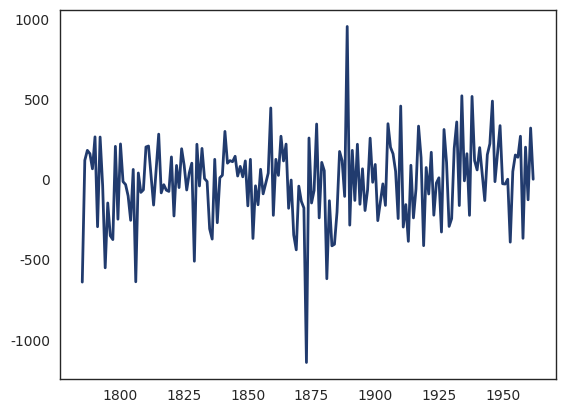

In [205]:
y_val.plot();

차분 그래프는 예측이 잘 맞는지 알기 어렵기 때문에 다시 종가로 바꿔서 비교해보겠습니다.

In [213]:
new_df1 = kodex200[(kodex200.index >= '2018-05-29')&(kodex200.index <= '2019-02-20')]
new_df1

,Open,High,Low,Close,Volume,Diff,return
Date,,,,,,,
2018-05-29,30363.0,30406.0,30121.0,30130.0,4686386.0,-283.0,-0.930523
2018-05-30,29998.0,30007.0,29313.0,29489.0,13822182.0,-641.0,-2.127448
2018-05-31,29622.0,29670.0,29483.0,29607.0,18580502.0,118.0,0.400149
2018-06-01,29622.0,29893.0,29501.0,29787.0,10163157.0,180.0,0.607964
2018-06-04,29831.0,30017.0,29793.0,29946.0,9397598.0,159.0,0.533790
...,...,...,...,...,...,...,...
2019-02-14,27599.0,27953.0,27471.0,27959.0,4946913.0,268.0,0.967823
2019-02-15,27836.0,27836.0,27471.0,27591.0,4185097.0,-368.0,-1.316213
2019-02-18,27725.0,27884.0,27667.0,27791.0,5345033.0,200.0,0.724874


In [ ]:
new_df2 = new_df1.drop(columns=['Open','High','Low','Volume','Diff','return'])

In [215]:
val_pred = pd.DataFrame(pred1).T
val_pred

,0,1,2,3,4,5,6,7,8,9
0,65.993252,-156.342426,-41.170678,-48.788699,-7.471099,-528.313087,-2.100102,-64.619002,-144.329831,-592.890381
1,478.110933,34.163538,3.391743,-255.672543,-115.084129,-208.296244,85.563058,-55.403227,-330.812906,-160.414684
2,854.413864,-86.683732,-41.389336,-178.307239,208.851061,-265.788374,134.388143,-77.077324,-187.320172,42.377836
3,463.515348,-210.143755,-12.195528,-228.869652,45.123174,-23.194893,103.714815,-32.868731,-102.531261,121.823183
4,1222.673722,-115.146649,74.535200,-50.112724,101.578314,-4.444488,-54.555182,-71.388573,206.160097,35.913685
...,...,...,...,...,...,...,...,...,...,...
173,383.201196,109.298430,25.579005,50.591879,-227.739253,48.241876,163.274629,-33.439944,52.453054,-294.487453
174,356.955466,117.493951,47.360212,-175.850035,-39.935591,11.274000,86.725255,-172.477607,-148.988597,-66.121519
175,293.068119,-56.465125,-133.672027,-83.590280,165.531524,72.646475,246.529843,-172.600364,-142.320043,-106.000907
176,743.224087,-128.507211,19.304533,0.724665,14.049624,17.626419,68.093326,-42.092200,-49.916056,149.582249


In [216]:
val_pred.iloc[0,:] = val_pred.iloc[0,:] + 30130.0
val_pred

,0,1,2,3,4,5,6,7,8,9
0,30195.993252,29973.657574,30088.829322,30081.211301,30122.528901,29601.686913,30127.899898,30065.380998,29985.670169,29537.109619
1,478.110933,34.163538,3.391743,-255.672543,-115.084129,-208.296244,85.563058,-55.403227,-330.812906,-160.414684
2,854.413864,-86.683732,-41.389336,-178.307239,208.851061,-265.788374,134.388143,-77.077324,-187.320172,42.377836
3,463.515348,-210.143755,-12.195528,-228.869652,45.123174,-23.194893,103.714815,-32.868731,-102.531261,121.823183
4,1222.673722,-115.146649,74.535200,-50.112724,101.578314,-4.444488,-54.555182,-71.388573,206.160097,35.913685
...,...,...,...,...,...,...,...,...,...,...
173,383.201196,109.298430,25.579005,50.591879,-227.739253,48.241876,163.274629,-33.439944,52.453054,-294.487453
174,356.955466,117.493951,47.360212,-175.850035,-39.935591,11.274000,86.725255,-172.477607,-148.988597,-66.121519
175,293.068119,-56.465125,-133.672027,-83.590280,165.531524,72.646475,246.529843,-172.600364,-142.320043,-106.000907
176,743.224087,-128.507211,19.304533,0.724665,14.049624,17.626419,68.093326,-42.092200,-49.916056,149.582249


In [222]:
val_pred2 = val_pred.cumsum()

In [223]:
val_pred2 = round(val_pred2, 1)
val_pred2

,0,1,2,3,4,5,6,7,8,9
0,30196.0,29973.7,30088.8,30081.2,30122.5,29601.7,30127.9,30065.4,29985.7,29537.1
1,30674.1,30007.8,30092.2,29825.5,30007.4,29393.4,30213.5,30010.0,29654.9,29376.7
2,31528.5,29921.1,30050.8,29647.2,30216.3,29127.6,30347.9,29932.9,29467.5,29419.1
3,31992.0,29711.0,30038.6,29418.4,30261.4,29104.4,30451.6,29900.0,29365.0,29540.9
4,33214.7,29595.8,30113.2,29368.2,30363.0,29100.0,30397.0,29828.6,29571.2,29576.8
...,...,...,...,...,...,...,...,...,...,...
173,54943.3,40043.6,32199.0,27991.9,31027.7,31512.2,31027.3,24750.0,15029.8,18330.6
174,55300.3,40161.1,32246.4,27816.1,30987.8,31523.4,31114.0,24577.5,14880.8,18264.4
175,55593.3,40104.6,32112.7,27732.5,31153.3,31596.1,31360.5,24404.9,14738.5,18158.4
176,56336.6,39976.1,32132.0,27733.2,31167.4,31613.7,31428.6,24362.8,14688.5,18308.0


In [225]:
val_pred2['avg'] = val_pred2.mean(axis=1)
val_pred2

,0,1,2,3,4,5,6,7,8,9,avg
0,30196.0,29973.7,30088.8,30081.2,30122.5,29601.7,30127.9,30065.4,29985.7,29537.1,29978.00
1,30674.1,30007.8,30092.2,29825.5,30007.4,29393.4,30213.5,30010.0,29654.9,29376.7,29925.55
2,31528.5,29921.1,30050.8,29647.2,30216.3,29127.6,30347.9,29932.9,29467.5,29419.1,29965.89
3,31992.0,29711.0,30038.6,29418.4,30261.4,29104.4,30451.6,29900.0,29365.0,29540.9,29978.33
4,33214.7,29595.8,30113.2,29368.2,30363.0,29100.0,30397.0,29828.6,29571.2,29576.8,30112.85
...,...,...,...,...,...,...,...,...,...,...,...
173,54943.3,40043.6,32199.0,27991.9,31027.7,31512.2,31027.3,24750.0,15029.8,18330.6,30685.54
174,55300.3,40161.1,32246.4,27816.1,30987.8,31523.4,31114.0,24577.5,14880.8,18264.4,30687.18
175,55593.3,40104.6,32112.7,27732.5,31153.3,31596.1,31360.5,24404.9,14738.5,18158.4,30695.48
176,56336.6,39976.1,32132.0,27733.2,31167.4,31613.7,31428.6,24362.8,14688.5,18308.0,30774.69


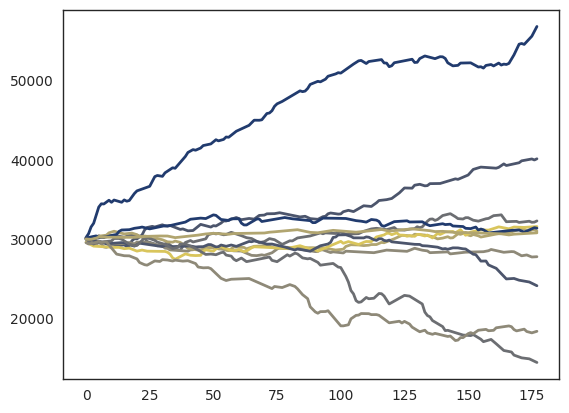

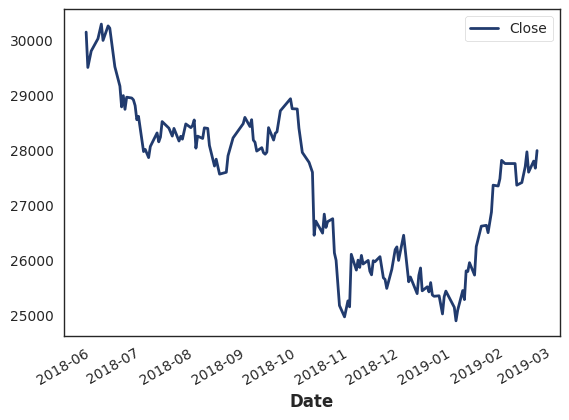

In [227]:
val_pred2.iloc[:,0].plot()
val_pred2.iloc[:,1].plot()
val_pred2.iloc[:,2].plot()
val_pred2.iloc[:,3].plot()
val_pred2.iloc[:,4].plot()
val_pred2.iloc[:,5].plot()
val_pred2.iloc[:,6].plot()
val_pred2.iloc[:,7].plot()
val_pred2.iloc[:,8].plot()
val_pred2.iloc[:,9].plot()
val_pred2.iloc[:, 10].plot()
new_df2.plot()

예측값과 실제값을 비교해보니 선형모델은 급락을 전혀 예측하지 못하는 것을 알 수 있습니다.

두 그래프를 같이 놓고 보겠습니다.

In [ ]:
val_pred2.index = new_df2.index


In [247]:
plot_df = pd.concat([new_df2['Close'], val_pred2['avg']], axis=1)
plot_df

,Close,avg
Date,,
2018-05-29,30130.0,29978.00
2018-05-30,29489.0,29925.55
2018-05-31,29607.0,29965.89
2018-06-01,29787.0,29978.33
2018-06-04,29946.0,30112.85
...,...,...
2019-02-14,27959.0,30685.54
2019-02-15,27591.0,30687.18
2019-02-18,27791.0,30695.48


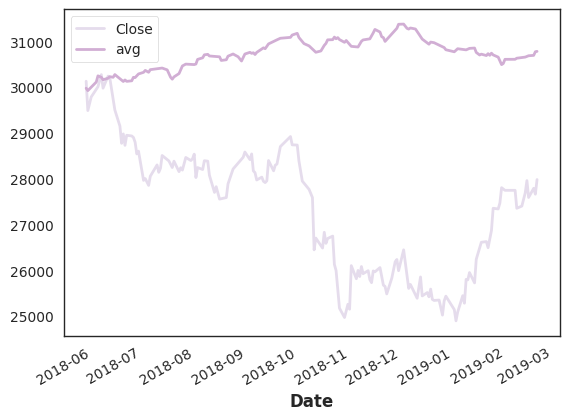

In [251]:
sns.set_palette('PuRd')
plot_df.plot()

cv로 예측한 값들의 평균과 실제 종가의 그래프입니다. 실제 종가가 2018년 7월부터 급격히 떨어지기 시작하는데 선형모델은 이를 전혀 예측하지 못합니다. 또한, 차분를 예측한 후 이를 누적합해서 종가를 만든 것이기 때문에 차분의 오차가 점점 쌓여서 실제 값과 더욱더 괴리되는 모습을 확인할 수 있습니다. 이런 급락이 있는 경우 모델 성능이 더 떨어지기 때문에 검증 데이터의 값에 따라 모델의 성능이 많이 차이날 것 같습니다.

모델 1의 예측에 중요한 영향을 미친 특성중요도를 살펴보겠습니다.

In [ ]:
!pip install eli5

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    ols,
    scoring='r2', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)


permuter.fit(X_val, y_val);

In [35]:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
122.2824 ± 12.9012,sma5
66.0549 ± 9.8161,ema5
8.1615 ± 0.9090,ema20
7.9629 ± 0.9076,MACD
4.3371 ± 0.3924,disparity
0.4008 ± 0.0629,Slow_k
0.0042 ± 0.0030,Slow_d
0.0033 ± 0.0034,Volume
-0.0022 ± 0.0065,RSI


모델 1에서 차분(Difference)를 예측하는 데 가장 중요한 특성으로는 단순이동평균(5일), 지수이동평균(5일), 지수이동평균(20일), MACD, 이격도가 있습니다. 이동평균이 높은 순위를 차지하고 있는데, 차분이 종가의 하루 차이인 것을 생각해보면, 단순이동평균은 5일 간의 평균이기 때문에 약간의 leakeage가 있다고 볼 수도 있습니다. 그런데 대부분의 랜덤워크 모형은 가격에서 파생된 특성으로 예측을 해서 모형 특성상 발생하는 애매한 부분인 것 같습니다.

## 모델 2 XGBoost Regressor

In [36]:
from xgboost import XGBRegressor
'''
target = 'Diff'
y =kodex200train[target]
X =kodex200train.drop(columns = target)

X = X.dropna()
y= y.dropna()

X = X.drop(columns='Date')
'''
scores_xgb = []
mse_xgb = []
preds_xgb = []

for train_index, val_index in tscv.split(kodex200train):

    X_train2   = X.iloc[train_index] #drop('Date', axis=1)
    y_train2 = y.iloc[train_index]

    X_val2  = X.iloc[val_index] #.drop('record_date', axis=1)
    y_val2  = y.iloc[val_index]

    # if needed, do preprocessing here

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0,
                            max_depth=7)
    xgb_model.fit(X_train2, y_train2)

    pred_xgb = xgb_model.predict(X_val2)
    preds_xgb.append(pred_xgb)

    r2score_xgb = xgb_model.score(X_val2,y_val2)
    scores_xgb.append(r2score_xgb)

    mse_xg = mean_squared_error(y_val2, pred_xgb)
    mse_xgb.append(mse_xg)
average_r2score_xgb = np.mean(scores_xgb)
print("평균 r2 score: ",average_r2score_xgb)
print("평균 mse: ",np.mean(mse_xgb))

[00:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

모델 2의 r2 score는 0.574이고 mse는 17490으로 모델 1보다 r2 score는 낮고 mse는 더 큽니다. 따라서 모델 1이 오류가 더 적은 모델이라고 할 수 있습니다. 


In [37]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter2 = PermutationImportance(
    xgb_model,
    scoring='r2', # metric
    n_iter=5, 
    random_state=2
)


permuter2.fit(X_val2, y_val2);

In [38]:
feature_names2 = X_val2.columns.tolist()
eli5.show_weights(
    permuter2, 
    top=None, 
    feature_names=feature_names2 
)

Weight,Feature
2.6808 ± 0.2699,disparity
0.7782 ± 0.1232,Slow_k
0.0602 ± 0.0440,MACD
0.0402 ± 0.0442,Slow_d
0.0050 ± 0.0095,RSI
0.0041 ± 0.0128,ema5
0.0008 ± 0.0009,ema20
0.0007 ± 0.0021,sma5
-0.0097 ± 0.0066,Volume


모델 2에서 차분(Difference)을 예측하는 데 가장 중요한 특성으로는 이격도, Stochastic %k, MACD, Stochastic %D가 있습니다. 이격도가 가장 중요한 특성으로 나왔는데, 이격도를 구하는데 종가와 이동평균이 필요한 것을 생각해보면 순위가 낮게 나온 sma5는 특성에서 제외해도 될 것 같습니다. 

##모델 3 ARIMA

시계열 예측에 많이 사용하는 ARIMA 모델을 사용해서 분석을 해보겠습니다. ARIMA 모델은 AR모델과 MA모델을 합친 것으로 p,d,q 세가지의 모수를 가집니다. p는 AR모형의 lag, d는 차분 횟수, q는 MA모형의 lag를 의미합니다. 정상성 확인하는 과정에서의 ACF, PACF 그래프를 보고 p = 1, d=1, q=0으로 유추하였습니다.

In [39]:
#모델1,2에서 사용된 훈련 데이터 + 검증 데이터
arima_df = kodex200[(kodex200.index<='2019-02-21') & (kodex200.index>'2011-03-15')] 

In [40]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(arima_df['Diff'], order=(1, 1, 0)) 
res = mod.fit(trend='c',full_output=True, disp=0)
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Diff   No. Observations:                 1954
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -13728.548
Method:                       css-mle   S.D. of innovations            272.287
Date:                Thu, 25 Feb 2021   AIC                          27463.096
Time:                        00:48:46   BIC                          27479.829
Sample:                             1   HQIC                         27469.247
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1148      4.096     -0.028      0.978      -8.144       7.914
ar.L1.D.Diff    -0.5040      0.020    -25.775      0.000      -0.542      -0.466
                                    Roots   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 1000x500 with 0 Axes>

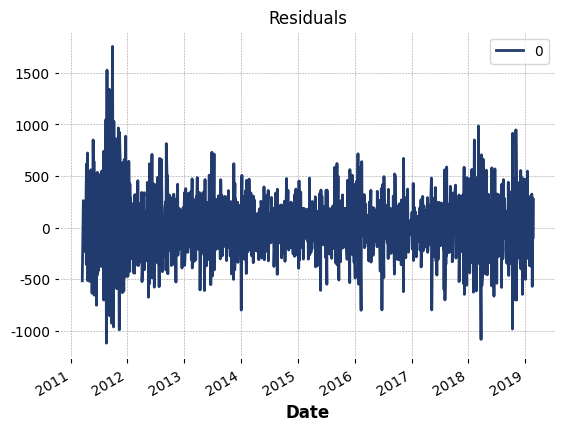

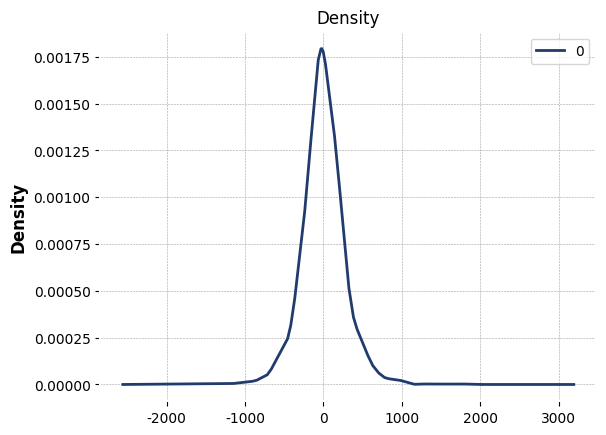

In [41]:
residuals = pd.DataFrame(res.resid)
fig = plt.figure(figsize=(10,5))

#ax1 = fig.add_subplot(1, 2, 1)
ax1 = residuals.plot(title="Residuals")

#ax2 = fig.add_subplot(1, 2, 2)
ax2 = residuals.plot(kind='kde', title='Density')

plt.show()

잔차그림을 그려봤을 때 어떤 경향도 보이지 않고 있습니다.

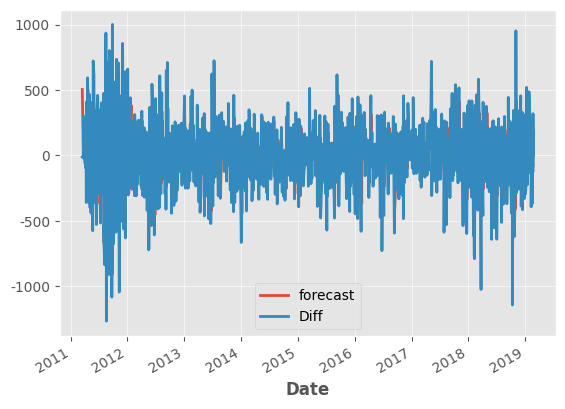

In [42]:
plt.style.use('ggplot')
res.plot_predict(dynamic=False)
plt.show()

ARIMA 모델로 예측한 값과 실제 차분의 그래프입니다. 이대로는 분석이 어렵고, 투명도 조절을 하거나 종가로 바꿔서 봐야할 것 같습니다.

이렇게 회귀분석 모델 세가지를 이용한 분석을 했는데, 회귀분석로는 의사결정 시그널을 주기 어려운 것 같습니다.
물론 차분을 예측해서 누적합을 하면 지수의 종가 예측값이 나오는데, 오차범위도 정해야 하고 모델이 너무 복잡해집니다.

이번엔 의사결정에 직접적으로 도움을 줄 수 있는 분류 모델로 다시 분석해 볼 것입니다. 

## 분류모델



## 모델 4 XGBoost Classifier

타겟은 종가가 ema20선보다 큰 값은 1, 아닌 값은 0으로 하겠습니다.

In [43]:
def engineer2(df):
  df = df.astype('float')
  
  #5일 단순이동평균(sma)
  df['sma5'] = df['Close'].rolling(window=5, min_periods=1).mean()

  
  #5일 지수이동평균(ema)
  df['ema5'] = df['Close'].ewm(5).mean()
  #20일 지수이동평균
  df['ema20'] = df['Close'].ewm(20).mean()

  #이격도
  df['disparity'] = df['Close'] - df['sma5']
  
  #Stochastic K, D : Fast %K의 m기간 이동평균(SMA)
  df['fast_k'] = ((df['Close'] - df['Low'].rolling(5).min()) / (df['High'].rolling(5).max() - df['Low'].rolling(5).min())) * 100
  df['Slow_k'] = df['fast_k'].rolling(3).mean()
  df['Slow_d'] = df['Slow_k'].rolling(3).mean()

  #MACD
  df['EMAFast'] = df['Close'].ewm( span = 5, min_periods = 4).mean()
  df['EMASlow'] = df['Close'].ewm( span = 20, min_periods = 19).mean()
  df['MACD'] = df['EMAFast'] - df['EMASlow']
  #df['MACDSignal'] = df['MACD'].ewm( span = 9, min_periods = 8).mean()
  #df['MACDDiff'] = df['MACD'] - df['MACDSignal']

  #RSI
  delta = df['Close'].diff(5)
  delta = delta.dropna()

  up = delta.copy()
  down = delta.copy()

  up[up<0] = 0
  down[down>0] = 0

  df['up'] = up
  df['down'] = down

  AVG_Gain = df['up'].rolling(window = 5).mean()
  AVG_Loss = abs(df['down'].rolling(window = 5).mean())
  RS = AVG_Gain/AVG_Loss

  RSI = 100.0 - (100.0/(1+RS))
  df['RSI'] = RSI 

  df['Diff'] =  np.r_[0, np.diff(df['Close'])]

  df = df.drop(columns=['Open', 'High','Low', 'fast_k', 'EMAFast', 'EMASlow', 'up', 'down'])
  df = df.dropna()

  df = df.reset_index() #time_series_split할 때 필요


  return df

In [44]:
#타겟값 만들기
def define_target_condition(df):
 
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Close'].shift(-20) > df.ema20.shift(-20), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [45]:
kodex200test2 = kodex200[-495:]
kodex200train2 = kodex200.drop(index=kodex200test2.index)
kodex200train2.shape, kodex200test2.shape

((1981, 7), (495, 7))

In [46]:
kodex200train2 = engineer2(kodex200train2)
kodex200test2 = engineer2(kodex200test2)
kodex200train2 =define_target_condition(kodex200train2)
kodex200test2 = define_target_condition(kodex200test2)

In [47]:
kodex200train2

,Date,Close,Volume,Diff,return,sma5,ema5,ema20,disparity,Slow_k,Slow_d,MACD,RSI,target_cls
0,2011-03-04,23019.0,2988882.0,463.0,2.052669,22481.2,22610.437164,22736.969876,537.8,70.175352,41.458034,-59.349788,28.901734,1
1,2011-03-07,22605.0,1770781.0,-414.0,-1.798514,22506.0,22609.506700,22726.884538,99.0,84.305362,64.341208,-54.506343,42.019544,1
2,2011-03-08,22852.0,971468.0,247.0,1.092679,22630.2,22650.820271,22736.178366,221.8,79.063633,77.848116,5.821892,77.543079,1
3,2011-03-09,22886.0,1878827.0,34.0,0.148783,22783.6,22690.739995,22747.018390,102.4,72.110651,78.493215,49.390538,100.000000,1
4,2011-03-10,22680.0,2194074.0,-206.0,-0.900114,22808.4,22688.922562,22742.286457,-128.4,62.669764,71.281349,26.912040,100.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,2019-02-15,27591.0,4185097.0,-368.0,-1.316213,27639.6,27520.781557,26747.801531,-48.6,72.251956,61.627824,454.878139,39.681134,0
1959,2019-02-18,27791.0,5345033.0,200.0,0.724874,27717.2,27565.817964,26797.477649,73.8,74.661591,72.174447,441.347109,74.977578,0
1960,2019-02-19,27663.0,4830085.0,-128.0,-0.460581,27739.0,27582.014970,26838.692999,-76.0,54.331917,67.081822,388.698325,94.405594,0
1961,2019-02-20,27982.0,6575502.0,319.0,1.153165,27797.2,27648.679142,26893.136189,184.8,65.337780,64.777096,420.554667,100.000000,0


베이스라인

In [65]:
kodex200train2['target_cls'].value_counts(normalize=True)

1    0.543556
0    0.456444
Name: target_cls, dtype: float64

In [203]:
print('베이스라인 모델 검증 정확도: ', 0.543556)

베이스라인 모델 검증 정확도:  0.543556


타겟의 분포는 고른 편이기 때문에 모델 생성시 타겟 클래스 비율을 고려할 필요는 없을 것 같습니다.

In [ ]:
eval_set = [(X_train2, y_train2), 
            (X_val2, y_val2)]

model.fit(X_train2, y_train2, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

In [48]:
kodex200train2 = kodex200train2.drop(columns = ['return','Diff'])

In [53]:
from xgboost import XGBClassifier
#from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

target2 = 'target_cls'

y2 =kodex200train2[target2]
X2 =kodex200train2.drop(columns = target2)

X2 = X2.dropna()
y2= y2.dropna()

X2 = X2.drop(columns='Date')

scores_xgbc = []
preds_xgbc = []
f1_score1 = []
prec_score = []
rec_score = []

for train_index, val_index in tscv.split(kodex200train2):

    X2_train   = X2.iloc[train_index] #drop('Date', axis=1)
    y2_train = y2.iloc[train_index]

    X2_val  = X2.iloc[val_index] #.drop('record_date', axis=1)
    y2_val  = y2.iloc[val_index]

    # if needed, do preprocessing here

    xgb = XGBClassifier(n_estimators=1000, learning_rate=0.08, gamma=0,
                            max_depth=7)
    #xgb.fit(X2_train, y2_train, eval_metric='error', early_stopping_rounds=50)
    eval_set = [(X2_train, y2_train), 
            (X2_val, y2_val)]

    xgb.fit(X2_train, y2_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) 

    pred_xgbc = xgb.predict(X2_val)
    preds_xgbc.append(pred_xgbc)

    score_xgbc = xgb.score(X2_val,y2_val)
    scores_xgbc.append(score_xgbc)

   # preci = precision_score(X2_val,pred_xgbc)
    #prec_score.append(preci)

    #recall_s = recall_score(X2_val, pred_xgbc)
    #rec_score.append(recall_s)

    #f1 = f1_score(X2_val, pred_xgbc)
    #f1_score1.append(f1)

average_score_xgbc = np.mean(scores_xgbc)
#average_f1_score = np.mean(f1_score1)
print("평균 accuracy score: ",average_score_xgbc)
#print("평균 f1: ",np.mean(average_f1_score))

[0]	validation_0-error:0.071038	validation_1-error:0.578652
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.071038	validation_1-error:0.578652
[2]	validation_0-error:0.04918	validation_1-error:0.578652
[3]	validation_0-error:0.04918	validation_1-error:0.578652
[4]	validation_0-error:0.054645	validation_1-error:0.573034
[5]	validation_0-error:0.060109	validation_1-error:0.573034
[6]	validation_0-error:0.043716	validation_1-error:0.578652
[7]	validation_0-error:0.038251	validation_1-error:0.573034
[8]	validation_0-error:0.038251	validation_1-error:0.567416
[9]	validation_0-error:0.038251	validation_1-error:0.561798
[10]	validation_0-error:0.043716	validation_1-error:0.561798
[11]	validation_0-error:0.043716	validation_1-error:0.567416
[12]	validation_0-error:0.038251	validation_1-error:0.578652
[13]	validation_0-error:0.043716	validation_1-error:0.5674

모델 4의 검증 정확도는 0.53으로 베이스라인 모델의 0.54보다 낮은 편입니다. 이를 GridSearchCv로 개선할 수 있는지 확인해 보겠습니다.

# 모델 최적화

GridSearchCv를 이용하여 모델 4의 하이퍼 파라미터 튜닝을 진행하겠습니다.

In [58]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

xgb_f = xgb.XGBClassifier()
param_search = {'booster' :['gbtree'],
                'max_depth' : [3, 5, 10],
                'gamma':[0,1,2,3],
                'n_estimators':[50, 100, 1000],
                'objective':['binary:logistic'],
                'random_state':[2]}

#tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=xgb_f, cv=tscv,
                        param_grid=param_search, scoring ='f1', verbose=1, n_jobs=-1)

gsearch.fit(X2_train, y2_train)
            

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     r...alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'gamma': [0, 1, 2, 3],
                         'max_depth': [3, 5, 10],
             

In [59]:
print('최적 하이퍼파라미터: ', gsearch.best_params_)
print('f1: ', gsearch.best_score_)

최적 하이퍼파라미터:  {'booster': 'gbtree', 'gamma': 3, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 2}
f1:  0.5844822029072546


위에서 나온 최적 하이퍼 파라미터 근처의 값으로 다시 gridsearchcv를 시행해보겠습니다.

In [60]:
xgb_f = xgb.XGBClassifier()
param_search = {'booster' :['gbtree'],
                'max_depth' : [5, 7],
                'gamma':[3, 4,5],
                'n_estimators':[100, 150, 200],
                'objective':['binary:logistic'],
                'random_state':[2]}


gsearch = GridSearchCV(estimator=xgb_f, cv=tscv,      #모델 1부터 쓰던 timeseries cv를 사용
                        param_grid=param_search, scoring ='f1', verbose=1, n_jobs=-1)

gsearch.fit(X2_train, y2_train)

print('최적 하이퍼파라미터: ', gsearch.best_params_)
print('f1: ', gsearch.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   35.1s finished


최적 하이퍼파라미터:  {'booster': 'gbtree', 'gamma': 3, 'max_depth': 5, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 2}
f1:  0.5844822029072546


처음에 시행한 gridsearchcv와 같은 하이퍼파라미터들이 선택되었습니다. 이를 사용하여 최종 모델을 만들겠습니다.

## 최종 모델

모델 4를 최적화한 모델을 최종 모델로 선정하여 검증세트 정확도와 f1 score를 확인하겠습니다.

In [62]:
pipe = gsearch.best_estimator_

In [66]:
y_pred_v = pipe.predict(X2_val)
accu_grid = accuracy_score(y2_val, y_pred_v)
f1_grid = f1_score(y2_val, y_pred_v)
print(f'검증세트 정확도: {accu_grid:,.3f}')
print(f'검증세트 f1 score: {f1_grid:,.3f}')

검증세트 정확도: 0.326
검증세트 f1 score: 0.434


최종 모델은 점수가 많이 낮은 편이지만, 비교적 최근인 검증세트까지 넣어서 훈련하면 성능이 더 좋아질 수도 있기 때문에,일단 검증세트까지 다시 넣어서 gridsearch를 다시 시행하겠습니다.

In [68]:
X2_train.columns

Index(['Close', 'Volume', 'sma5', 'ema5', 'ema20', 'disparity', 'Slow_k',
       'Slow_d', 'MACD', 'RSI'],
      dtype='object')

In [69]:
X_train3 = kodex200train2.drop(columns=['Date','target_cls'])
y_train3 = kodex200train2['target_cls']
X_train3.shape, y_train3.shape

((1963, 10), (1963,))

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

xgb_f = xgb.XGBClassifier()
param_search = {'booster' :['gbtree'],
                'max_depth' : [3, 5, 10],
                'gamma':[0,1,2,3],
                'n_estimators':[50, 100, 1000],
                'objective':['binary:logistic'],
                'random_state':[2]}

#tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=xgb_f, cv=tscv,
                        param_grid=param_search, scoring ='f1', verbose=1, n_jobs=-1)

gsearch.fit(X_train3, y_train3)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     r...alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'gamma': [0, 1, 2, 3],
                         'max_depth': [3, 5, 10],
             

In [72]:
kodex200test2

X_test = kodex200test2.drop(columns=['Date','target_cls'])
y_test = kodex200test2['target_cls']
X_test.shape, y_test.shape

((477, 12), (477,))

In [78]:
X_test = X_test.drop(columns=['Diff','return'])

In [74]:
pipe2 = gsearch.best_estimator_

In [80]:
y_pred = pipe2.predict(X_test)
accu_grid2 = accuracy_score(y_test, y_pred)
f1_grid2 = f1_score(y_test, y_pred)
print(f'테스트세트 정확도: {accu_grid2:,.3f}')
print(f'테스트세트 f1 score: {f1_grid2:,.3f}')

테스트세트 정확도: 0.570
테스트세트 f1 score: 0.600


검증세트까지 넣어서 만든 모델의 테스트세트 정확도와 f1 score 모두 오른 것을 확인할 수 있습니다. 시계열 분석을 할 때는 무조건 데이터가 많다고 좋은 것이 아니 때문에 훈련데이터, 검증데이터, 테스트데이터를 나누는 기준이 중요할 것 같습니다. 이번 분석에서는 총 10년 간의 데이터 중에서 테스트데이터를 최근 20%로 잡고 모델링했는데, 데이터 크기를 더 줄이면(최신 데이터로 학습) 성능이 더 좋아지지 않을까 생각됩니다.

ROC curve와 AUC 점수 확인

Text(0, 0.5, 'TPR')

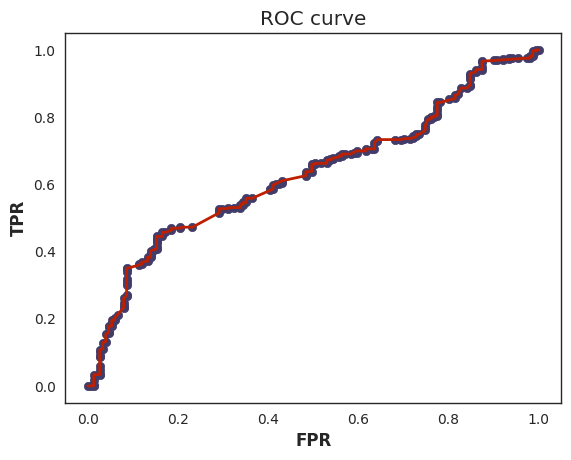

In [202]:
#ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.scatter(fpr, tpr, color='#413c69')
plt.plot(fpr, tpr, color='#bd2000')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [81]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe2.predict_proba(X_test)[:, -1]
print('AUC score: ', roc_auc_score(y_test, y_pred_proba))

AUC score:  0.631038475602324


ROC Curve를 보면 대각선보다는 그래프가 오목한 것(우측 하단 기준)을 알 수 있습니다. 하지만 AUC 점수가 0.63인 것을 보아 성능이 아주 좋아보이지는 않습니다.

# 특성중요도

In [87]:
# permuter 정의
permuter_f = PermutationImportance(
    pipe2, # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

permuter_f.fit(X_test, y_test);

In [88]:
feature_names_f = X_test.columns.tolist()
pd.Series(permuter_f.feature_importances_, feature_names_f).sort_values()

# 특성별 score 확인  #여러 번 섞은 결과임
eli5.show_weights(
    permuter_f, 
    # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_f # list 형식으로 넣어야 합니다
)

Weight,Feature
0.1245 ± 0.0366,ema20
0.0273 ± 0.0219,MACD
0.0096 ± 0.0225,Close
0.0087 ± 0.0098,disparity
0.0022 ± 0.0140,Slow_k
0.0018 ± 0.0036,Slow_d
0 ± 0.0000,RSI
-0.0073 ± 0.0049,Volume
-0.0103 ± 0.0117,ema5
-0.0949 ± 0.0161,sma5


모델 4의 경우 타겟을 예측하는 데 가장 중요한 특성으로는 20일 지수이동평균, MACD, 종가, 이격도, Stochastic %k 등이 있습니다. 이때 20일 지수이동평균은 타겟을 만드는 데 사용하였기 때문에 Leakage 문제가 있습니다. 하지만, 타겟을 미래의 종가가 20일 지수이동평균 보다 높은 지를 예측하는 것으로 했기 때문에 모델 설계상 필연적으로 발생할 수밖에 없었던 문제 같습니다. 거래량이 낮은 상관관계를 보이는 것이 특이했고, 모델 1,2,3과 다르게 5일 단순이동평균(sma5)이 가장 덜 중요한 특성으로 나온 것이 특이점입니다.

이제 개별 샘플을 예시로 특성 설명을 하겠습니다.

In [90]:
X_test.tail(5)

,Close,Volume,sma5,ema5,ema20,disparity,Slow_k,Slow_d,MACD,RSI
472,43025.0,17530618.0,42978.0,42865.729350,41172.933562,47.0,72.259991,66.491002,503.566897,69.729730
473,42410.0,8841408.0,42983.0,42789.774458,41231.841487,-573.0,49.671362,65.099328,304.727689,81.327801
474,42780.0,9728222.0,43003.0,42788.145382,41305.563321,-223.0,39.814390,53.915248,263.214272,100.000000
475,42330.0,8518245.0,42808.0,42711.787818,41354.346020,-478.0,31.806966,40.430906,122.675567,54.439252
476,42285.0,7733807.0,42566.0,42640.656515,41398.662877,-281.0,38.042011,36.554456,23.297442,22.103387


In [ ]:
!pip install shap

In [91]:
row = X_test.iloc[[-1]]
pipe2.predict(row)

array([0])

마지막 샘플(2021년 2월 23일)의 타겟 예측값은 0(종가가 20일 지수이동평균 보다 낮다)입니다. 이러한 예측에 영향을 준 특성들을 살펴보겠습니다. 

In [92]:
import shap

explainer = shap.TreeExplainer(pipe2)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,       
    features=row
)

예측하는 데 긍정적 영향을 준 것은 5일 지수이동평균, 종가이고 부정적 영향을 준 것은 5일 단순이동평균과 20일 지수이동평균입니다. 

이번 분석을 하면서 느꼈던 아쉬운 점과 개선점을 생각해봤습니다.

아쉬운 점 및 개선방법

1. 시계열 데이터 분석이 미숙하여 회귀 분석 모델을 활용하지 못한 것
모델 1, 2, 3은 회귀 분석 모델인데 시계열 데이터의 cv 방법이 익숙하지 않고, 데이터를 정상화해서 타겟 설정이 어려운 것과 ARIMA 모델은 처음 사용해 보는 등 과제를 수행하는 데 있어 여러 어려움이 있었습니다. 다음에 시계열 분석을 시도한다면 타겟을 오차범위 내 수익률 등으로 바꾸면 해석이 더 용이할 것 같습니다.

2. 시계열 분석에 머신러닝이 적합한지에 대한 의문. 
많은 블로그를 보면 시계열 예측에 트리기반 모델 등 머신러닝 모델보다는 LSTM 같은 딥러닝 모델을 많이 사용하는 것 같습니다. 지난 과제에서 집값 예측 등 시계열 분석에 사용한 회귀분석 등이 있었지만, 랜덤워크 모형처럼 가격을 기반으로 예측할 때는 다른 모델이 더 적절할 것 같습니다. 

머신러닝을 이용한 분석은 여기까지입니다. 아래의 분석은 제가 설정한 시나리오 상 20일 간 지수이동평균을 넘을 것이라고 분류된 ETF들을 어떻게 포트폴리오로 구성할 지에 대한 것입니다.

#다른 ETF 분석

국내 지수 

In [93]:
tiger200  = web.DataReader('102110', 'naver', start='2011-02-01', end='2021-02-23')
tiger200


,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,23191,23266,23102,23158,185383
2011-02-07,23458,23551,23238,23250,148168
2011-02-08,23244,23310,23060,23076,176990
2011-02-09,23071,23121,22773,22817,175734
2011-02-10,22756,22781,22441,22461,228444
...,...,...,...,...,...
2021-02-17,43180,43180,42565,42885,4093591
2021-02-18,42705,42950,42215,42215,1101011
2021-02-19,42235,42635,41570,42605,1513182


국내 업종/테마 

In [94]:
kodex_samsung = web.DataReader('102780', 'naver', start='2016-12-27', end='2021-02-23')
kodex_samsung

,Open,High,Low,Close,Volume
Date,,,,,
2016-12-27,4988,5003,4975,4981,58425
2016-12-28,5003,5051,5003,5019,57925
2016-12-29,4936,5041,4936,5028,138453
2017-01-02,5008,5008,4955,5010,44503
2017-01-03,5017,5055,4984,5043,88821
...,...,...,...,...,...
2021-02-17,10665,10665,10515,10600,221530
2021-02-18,10590,10605,10455,10455,184494
2021-02-19,10450,10450,10215,10420,415969


국내 파생

In [96]:
kodex200_lev2 = web.DataReader('122630', 'naver', start='2011-02-01', end='2021-02-23')
kodex200_lev2

,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,16300,16315,16100,16150,1749121
2011-02-07,16470,16665,16245,16245,3048721
2011-02-08,16370,16380,16000,16030,3002822
2011-02-09,16095,16110,15600,15640,3980138
2011-02-10,15610,15615,15135,15180,5245033
...,...,...,...,...,...
2021-02-17,27860,27890,27195,27600,32446979
2021-02-18,27435,27710,26750,26805,33226326
2021-02-19,26835,27295,25915,27250,47141287


해외 주식

In [97]:
tiger_nasdaq100 = web.DataReader('133690', 'naver', start='2011-02-01', end='2021-02-23')
tiger_nasdaq100

,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,11250,11250,10964,10984,2696
2011-02-07,11161,11176,11117,11172,3982
2011-02-08,11402,11402,11142,11177,2399
2011-02-09,11352,11352,11201,11251,2831
2011-02-10,11265,11343,11265,11345,787
...,...,...,...,...,...
2021-02-17,68485,68485,68065,68400,91111
2021-02-18,67915,68000,67510,67800,130402
2021-02-19,67600,67655,67270,67540,101227


원자재

In [99]:
kodex_gold = web.DataReader('132030', 'naver', start='2011-02-01', end='2021-02-23')
kodex_gold

,Open,High,Low,Close,Volume
Date,,,,,
2011-02-01,10150,10185,10120,10170,11389
2011-02-07,10220,10270,10220,10270,30513
2011-02-08,10290,10290,10260,10270,3285
2011-02-09,10350,10375,10345,10370,8416
2011-02-10,10370,10380,10345,10360,40170
...,...,...,...,...,...
2021-02-17,12215,12250,12195,12215,317382
2021-02-18,12140,12185,12130,12170,351577
2021-02-19,12085,12120,12015,12095,387400


채권

In [100]:
kodex_bond_short = web.DataReader('153130', 'naver', start='2011-02-01', end='2021-02-23')
kodex_bond_short

,Open,High,Low,Close,Volume
Date,,,,,
2012-02-22,87270,87274,87270,87277,55389
2012-02-23,87296,87299,87291,87299,21750
2012-02-24,87303,87303,87299,87303,7850
2012-02-27,87304,87308,87299,87308,4567
2012-02-28,87321,87326,87316,87320,8612
...,...,...,...,...,...
2021-02-17,102710,102715,102705,102715,15979
2021-02-18,102720,102720,102715,102715,17274
2021-02-19,102725,102725,102715,102720,17668


#포트폴리오 구성

In [ ]:
assets = [ 'KODEX200', 'KODEX_Samsung', 'KODEX_WTI', 'KODEX_Bond_Short', 'TIGER_Nasdaq', 'KODEX_LEV']

In [103]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) #여기 일단 다섯개

In [108]:
#각 etf별 종가 df로 만들기
df = pd.concat([kodex_gold['Close'], tiger_nasdaq100['Close'], kodex200_lev2['Close'], kodex_samsung['Close'], tiger200['Close']],
               keys=['Kodex_gold','Tiger_nasdaq','Kodex200_lev2','Kodex_samsung','Tiger200'],axis =1)
df

,Kodex_gold,Tiger_nasdaq,Kodex200_lev2,Kodex_samsung,Tiger200
Date,,,,,
2011-02-01,10170,10984,16150,NaN,23158
2011-02-07,10270,11172,16245,NaN,23250
2011-02-08,10270,11177,16030,NaN,23076
2011-02-09,10370,11251,15640,NaN,22817
2011-02-10,10360,11345,15180,NaN,22461
...,...,...,...,...,...
2021-02-17,12215,68400,27600,10600,42885
2021-02-18,12170,67800,26805,10455,42215
2021-02-19,12095,67540,27250,10420,42605


In [109]:
df = df.dropna()
df

,Kodex_gold,Tiger_nasdaq,Kodex200_lev2,Kodex_samsung,Tiger200
Date,,,,,
2016-12-27,8720,26631,11260,4981,23915
2016-12-28,8735,26799,11355,5019,24018
2016-12-29,8780,26463,11365,5028,24013
2017-01-02,8900,26339,11440,5010,24115
2017-01-03,8845,26408,11625,5043,24306
...,...,...,...,...,...
2021-02-17,12215,68400,27600,10600,42885
2021-02-18,12170,67800,26805,10455,42215
2021-02-19,12095,67540,27250,10420,42605


In [113]:
df = df.astype('float')

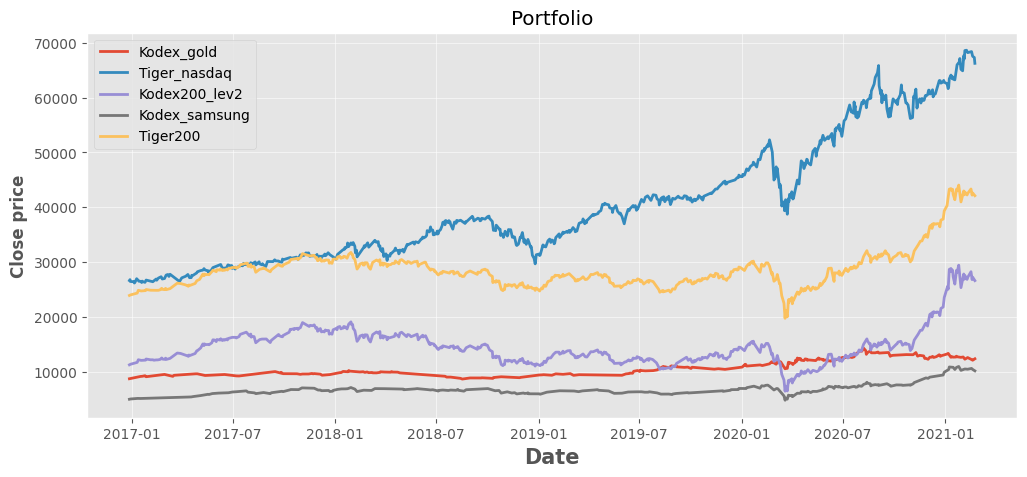

In [114]:
#시각화
title = 'Portfolio'

my_etf = df
plt.figure(figsize=(12,5))

for c in my_etf.columns.values:
  plt.plot(my_etf[c], label=c)

plt.title(title)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close price')
plt.legend(my_etf.columns.values, loc = 'upper left')
plt.show()

In [115]:
#일일수익률
returns = df.pct_change()
returns

,Kodex_gold,Tiger_nasdaq,Kodex200_lev2,Kodex_samsung,Tiger200
Date,,,,,
2016-12-27,NaN,NaN,NaN,NaN,NaN
2016-12-28,0.001720,0.006308,0.008437,0.007629,0.004307
2016-12-29,0.005152,-0.012538,0.000881,0.001793,-0.000208
2017-01-02,0.013667,-0.004686,0.006599,-0.003580,0.004248
2017-01-03,-0.006180,0.002620,0.016171,0.006587,0.007920
...,...,...,...,...,...
2021-02-17,-0.018087,-0.001314,-0.022663,-0.003759,-0.010384
2021-02-18,-0.003684,-0.008772,-0.028804,-0.013679,-0.015623
2021-02-19,-0.006163,-0.003835,0.016601,-0.003348,0.009238


In [116]:
returns = returns.dropna()

In [117]:
#연간 공분산 행렬
cov_matrix_annual = returns.cov() * 251
cov_matrix_annual

,Kodex_gold,Tiger_nasdaq,Kodex200_lev2,Kodex_samsung,Tiger200
Kodex_gold,0.020412,-0.000477,0.006798,0.003654,0.003475
Tiger_nasdaq,-0.000477,0.038543,0.034244,0.017242,0.017300
Kodex200_lev2,0.006798,0.034244,0.138343,0.070187,0.069121
Kodex_samsung,0.003654,0.017242,0.070187,0.043266,0.035195
Tiger200,0.003475,0.017300,0.069121,0.035195,0.034755


In [118]:
#포트폴리오 분산의 기댓값 = weight.T dot (공분산행렬) dot weight
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.03155187028233198

In [119]:
#포트폴리오 변동성의 기댓값 = 분산의 기댓값의 제곱근(표준편차)
port_volatility = np.sqrt(port_variance)
port_volatility

0.17762846135214924

In [120]:
#포트폴리오 연간 단순 수익률
port_annual_return = np.sum(returns.mean()*weights)*251

In [121]:
#예상 연간 수익, 변동성 또는 위험 및 분산
percent_var = str(round(port_variance, 2) * 100)
percent_vols = str(round(port_volatility, 2) * 100)
percent_ret = str(round(port_annual_return, 2)* 100)
print("예상 연간수익률: ", percent_ret, '%')
print("예상 변동성: ", percent_vols, '%')
print("예상 분산: ", percent_var, '%')

예상 연간수익률:  20.0 %
예상 변동성:  18.0 %
예상 분산:  3.0 %


In [124]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 1.0MB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.10-cp37-cp37m-linux_x86_64.whl size=2684353 sha256=f18ccfe046741cfadc78363fab952115397c70ba4ade4704a8bacbe86da3f5f7
  Stored in directory: /root/.cache/pip/wheels/64/d6/c9/9295499aefa5af80018eaabffd09216170a1349b45551fb8d5
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [125]:
#포트폴리오 최적화
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns

In [127]:
mu = expected_returns.mean_historical_return(df)
s = risk_models.sample_cov(df)

In [128]:
ef = EfficientFrontier(mu,s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('Kodex_gold', 0.32051), ('Tiger_nasdaq', 0.52566), ('Kodex200_lev2', 0.0), ('Kodex_samsung', 0.15383), ('Tiger200', 0.0)])
Expected annual return: 19.2%
Annual volatility: 13.0%
Sharpe Ratio: 1.32


(0.19163886699089616, 0.12971409172026344, 1.3232091033027171)

펀드의 위험성을 평가하기 위해 샤프 비율을 사용합니다. 샤프 비율은 투자자가 부담하는 위험을 자산 수익률이 얼마나 잘 보상하는지를 규정합니다. 두 자산을 공동의 기준지표와 비교할 경우, 더 높은 샤프 비율을 나타내는 자산이 동일한 위험에 대해 더 높은 수익률을 제공합니다.

샤프 비율은 기간에 따라 달라질 수 있습니다. 일일수익률, 주간수익률, 1개월수익률 모두 샤프비율을 구할 수 있습니다.

In [129]:
#개별 종목 할당
!pip install pulp

     |████████████████████████████████| 40.6MB 109kB/s 


In [204]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.lp_portfolio()

print("자산 분배: ", allocation)
print("남은 계좌 잔액: \{:.2f}".format(leftover))

자산 분배:  {'Kodex_gold': 26, 'Tiger_nasdaq': 8, 'Kodex_samsung': 14}
남은 계좌 잔액: \6360.00


다섯 가지 분야에 골고루 투자하는 위험중립형 투자자의 경우 최적화된 포트폴리오의 추천은 kodex골드, tiger나스닥100, kodex 삼성그룹을 각각 26, 8, 14개 매수할 것을 추천하고 있습니다.
